In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score, accuracy_score, \
balanced_accuracy_score, confusion_matrix, roc_curve, auc, \
precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer

import copy
import warnings 
import os 
import random
warnings.filterwarnings("ignore")

import umap
from numpy import linalg as LA
from helper import *

In [2]:
METHODS = ['fedavg', 'fca']

LOSS_OPTION = ['ce','focal','bsm']

NUM_CLASS = 8
BATCH_SIZE = 64
NUM_WORKERS = 8

epochs = 80
lr, momentum, wd = 1e-3, 0.9, 5e-4
epochs_lr_decay  = [60, 70]
lr_decay = 0.1
device = torch.device('cuda:0')

color_code = ['b','g','r','c','m','y','k']

## select the experiment setting

In [3]:
# extra hyperparameter for FCA, LAM1 = global, LAM2 = local
LAM1, LAM2, CONSISTENCY = 1,3, True

FCA_PARAMS = {'LAM1':LAM1,'LAM2':LAM2, 'CONSISTENCY':CONSISTENCY}

LOSS_ = LOSS_OPTION[2]
SELECTED = METHODS[1] 
if SELECTED == 'fca':
    FCA_ = True
    head = ['standard_head2.weight','standard_head2.bias']
else:
    FCA_ = False
    head = []

In [4]:
PTH = '../datasets/isic/'
PTH_gt = PTH +  'ISIC_2019_Training_GroundTruth.csv'
PTH_metadata = PTH + 'ISIC_2019_Training_Metadata.csv'
PTH_DATA = PTH + 'isic2019_processed/'
PTH_split = '[isic]train_test_split'
train_split = pd.read_csv(PTH_split)

CLIENTS = ['BCN', 'vidir_molemax', 'vidir_modern', 'rosendahl', 'MSK4', 'vienna_dias']
TOTAL_CLIENTS = len(CLIENTS)

## load the data

In [5]:
split_per_center = dict()
train_data = dict()
test_data = dict()


global_train_img = []
global_train_lbl = []
global_test_img = []
global_test_lbl = []
for i in range(6):
    split_per_center[i] = train_split[train_split['center'] == i]
    lbl_ = split_per_center[i]['target']
    
    ## get the train and test split
    train_idx = [True if f.split('_')[0]=='train' else \
                 False for f in split_per_center[i]['fold2']]
    
    test_idx = [True if f.split('_')[0]=='test' else \
                 False for f in split_per_center[i]['fold2']]

    '''
    testing
    '''
    train_data[CLIENTS[i]] = {"image":np.array([PTH_DATA+fname+'.jpg' for \
                                                    fname in split_per_center[i][train_idx]['image']]),\
                                  "label":np.array([int(lbl) for lbl in lbl_[train_idx]])}

    test_data[CLIENTS[i]] = {"image":np.array([PTH_DATA+fname+'.jpg' for \
                                                    fname in split_per_center[i][test_idx]['image']]),\
                                  "label":np.array([int(lbl) for lbl in lbl_[test_idx]])}

    global_train_img+= [PTH_DATA+fname+'.jpg' for fname in split_per_center[i][train_idx]['image']]
    global_train_lbl+= [int(lbl) for lbl in lbl_[train_idx]]
    
    global_test_img+= [PTH_DATA+fname+'.jpg' for fname in split_per_center[i][test_idx]['image']]
    global_test_lbl+= [int(lbl) for lbl in lbl_[test_idx]]
    
    
    ##################################
    tmp_ = np.array([int(lbl) for lbl in lbl_])
    print('center ', i, ':', np.unique(tmp_,return_counts=True))
    clstype, clsamt = np.unique(tmp_, return_counts=True)
    
    
    print('total data', len(tmp_))
    print('train ratio: , ', np.sum(np.array(train_idx))/len(tmp_))
    print()
    
train_data['global'] = {"image":np.array(global_train_img), "label":np.array(global_train_lbl)}
test_data['global'] = {"image":np.array(global_test_img), "label":np.array(global_test_lbl)}

center  0 : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([2857, 4206, 2809,  737, 1138,  124,  111,  431]))
total data 12413
train ratio: ,  0.7999677757190042

center  1 : (array([0, 1, 2, 4, 5, 6]), array([  24, 3720,    2,  124,   30,   54]))
total data 3954
train ratio: ,  0.7999494183105715

center  2 : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 680, 1832,  211,   21,  475,   51,   82,   11]))
total data 3363
train ratio: ,  0.800178412132025

center  3 : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([342, 803, 296, 109, 490,  30,   3, 186]))
total data 2259
train ratio: ,  0.7999114652501107

center  4 : (array([0, 1, 4]), array([215, 415, 189]))
total data 819
train ratio: ,  0.7997557997557998

center  5 : (array([0, 1, 2, 4, 5, 6]), array([ 67, 350,   5,  10,   4,   3]))
total data 439
train ratio: ,  0.7995444191343963



## dataloader

In [6]:
#########################
# Class for loading the #
# skin dataset          #
#########################
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]


class cancer(Dataset):
    def __init__(self, im_path, class_label, \
                 transformation=None, num_class=8):
        self.data = im_path
        self.label = class_label
        self.transform = transformation
        self.num_class = num_class
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        image = Image.open(self.data[idx])
        if self.transform: # augmentation
            image = self.transform(image)
        else:
            image = Resize((224,224))(image)
            image = TF.to_tensor(image)
        label = self.label[idx]
        label_onehot = torch.FloatTensor(self.num_class).zero_()
        label_onehot[label] = 1.0
        
        return image, label, idx, label_onehot
    
input_transform_train = Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    RandomRotation(degrees=(-10,10)),
    Resize((224,224)),
    ToTensor(),
    Normalize(norm_mean, norm_std)
])

input_transform_test = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(norm_mean, norm_std)
])


In [7]:
CE_loss = nn.CrossEntropyLoss(reduction='none')
clsnm_, criterions_, loader = dict(), dict(), dict()
_, clsnm_global = np.unique(train_data['global']['label'], return_counts=True)

for cl_name in CLIENTS:
    loader['train_'+cl_name] = DataLoader(cancer(train_data[cl_name]['image'], \
                                               train_data[cl_name]['label'], input_transform_train), \
                                        shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    loader['test_'+cl_name] = DataLoader(cancer(test_data[cl_name]['image'], \
                                               test_data[cl_name]['label'], input_transform_test), \
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    cls, clsnm = np.unique(train_data[cl_name]['label'], return_counts=True)
    clsnm_[cl_name] = np.zeros(NUM_CLASS)
    for idx, i in enumerate(cls):
        clsnm_[cl_name][i] = clsnm[idx]
        
    if LOSS_ == 'ce':
        criterions_[cl_name] = CE_loss
    if LOSS_ == 'focal':
        criterions_[cl_name] = FocalLoss(gamma=1)
    if LOSS_ == 'bsm':
        criterions_[cl_name] = CustomLoss(clsnm_[cl_name], \
                                          CE_loss,device, balance=True)

loader['global_train'] = DataLoader(cancer(train_data['global']['image'], \
                                               train_data['global']['label'], input_transform_train), \
                                        shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
loader['global'] = DataLoader(cancer(test_data['global']['image'], \
                                               test_data['global']['label'], input_transform_test), \
                                        shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [8]:
# binarize label
label_binarizer = LabelBinarizer().fit(train_data['global']['label'].astype('int'))

########
global eval
overall set acc last epoch:  0.5762444237259002  best,  0.5762444237259002
avg auc now: 0.9108899350022042 avg auc best: 0.9108899350022042
#######
pc eval
avg acc per client, 0.7107124738460205 0.7107124738460205
avg auc now: 0.9163793343750406 avg auc best: 0.9163793343750406


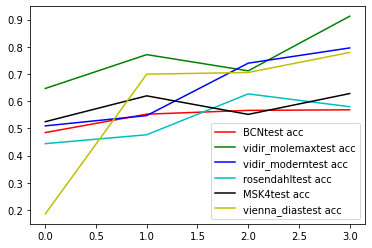

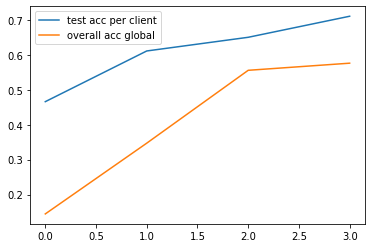

epoch number 4 


In [ ]:
best_avg_acc = 0.0
best_global_acc = 0.0
epoch_best_avg = 0
epoch_best_global_avg = 0

acc_train, loss_train, acc_test = dict(), dict(), dict() 
avg_auc_ = dict()
avg_auc_['global']= []

nets, optimizers, schedulers = dict(), dict(), dict()
weights = dict()

index = [] 
#### additional storage ####
test_acc_avg = []
best_test_acc = []
overall_acc_test = []
pc_avg_auc=[]

###############################################
### federated model #####
tmp = models.efficientnet_b0(pretrained=True)
tmp.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASS, bias=True)
if FCA_:
    nets['global'] = customized_effnet(tmp, classnum=NUM_CLASS)
else:
    nets['global'] = tmp
nets['global'].to(device)
##########################
total = 0
num_client = 0
for key,_ in loader.items():
    if key[:4] == 'test':
        tmp = key[5:]
        acc_train[tmp], loss_train[tmp] = [], []
        acc_test[tmp] = []
        avg_auc_[tmp] = []
        #########################################
        weights[tmp] = len(loader['train_'+tmp].dataset)
        total += weights[tmp]
        num_client += 1
        tmp_ = models.efficientnet_b0(pretrained=True)
        tmp_.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASS, bias=True)
        if FCA_:
            nets[tmp] = customized_effnet(tmp_, classnum=NUM_CLASS)
        else:
            nets[tmp] = tmp_
        nets[tmp].to(device)
        optimizers[tmp] = optim.Adam(nets[tmp].parameters(), lr=lr, \
           weight_decay=wd)
        schedulers[tmp] = optim.lr_scheduler.MultiStepLR(optimizers[tmp],
                                                      milestones=epochs_lr_decay,
                                                      gamma=lr_decay)
# assign federated average weight
WEIGHTS_CL = np.zeros(num_client)
for idx, cl_name in enumerate(CLIENTS):
    WEIGHTS_CL[idx] = weights[cl_name]/total * 1.0

for epoch in range(80):
    index.append(epoch) 
    print("epoch number %d " % epoch)
    # aggregate model and download to client
    aggr_fed(CLIENTS, WEIGHTS_CL, nets, fed_name='global', head=[])
    copy_fed(CLIENTS, nets, fed_name='global', head=head)
    '''
    Evaluate federated model - global evaluation / generalization
    '''
    criterion = nn.CrossEntropyLoss().to(device)
    test(loader['global'], nets['global'], criterion, device, \
        acc_arr=overall_acc_test, avg_auc=avg_auc_['global'], \
         global_=True, FCA_=FCA_, label_binarizer=label_binarizer, NUM_CLASS=NUM_CLASS)   
    
    '''
    training
    '''
    for client, _ in acc_train.items():        
        criterion = criterions_[client]
        schedulers[client].step() # step        
        train(loader['train_'+client], nets[client], optimizers[client], \
                  criterion, device,acc_arr= acc_train[client], loss_arr=loss_train[client], FCA_=FCA_,\
             FCA_PARAMS=FCA_PARAMS)

    '''
    per client evaluation - specialization
    '''
    avg_acc = 0.0
    avg_auc = 0
    criterion = nn.CrossEntropyLoss().to(device)
    for client, _ in acc_test.items():
        test(loader['test_'+client], nets[client], criterion, device, \
            acc_test[client], avg_auc=avg_auc_[client], \
             global_=False, FCA_=FCA_, label_binarizer=label_binarizer, NUM_CLASS=NUM_CLASS)
        avg_acc += acc_test[client][-1]
        avg_auc += avg_auc_[client][-1]
        
    test_acc_avg.append(avg_acc/TOTAL_CLIENTS)
    pc_avg_auc.append(avg_auc/TOTAL_CLIENTS)
    avg_acc = avg_acc/TOTAL_CLIENTS
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        epoch_best_avg = epoch
    if overall_acc_test[-1] > best_global_acc:
        best_global_acc = overall_acc_test[-1]
        epoch_best_global_avg = epoch
                
    clear_output(wait=True)
    
    print('########')
    print('global eval')
    print('overall set acc last epoch: ', overall_acc_test[-1], ' best, ', \
         overall_acc_test[epoch_best_global_avg])
    print('avg auc now:', avg_auc_['global'][-1], \
         'avg auc best:', avg_auc_['global'][epoch_best_global_avg])
    print('#######')
    print('pc eval')
    print('avg acc per client,',test_acc_avg[-1], best_avg_acc)
    print('avg auc now:', pc_avg_auc[-1], \
         'avg auc best:', pc_avg_auc[epoch_best_avg])


    plot_graphs(1, CLIENTS, index, acc_test, 'test acc')
    plt.figure(2)
    plt.plot(index, test_acc_avg, label= 'test acc per client')
    plt.plot(index, overall_acc_test, label='overall acc global')
    plt.legend()
    plt.show()